# setup

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# input data

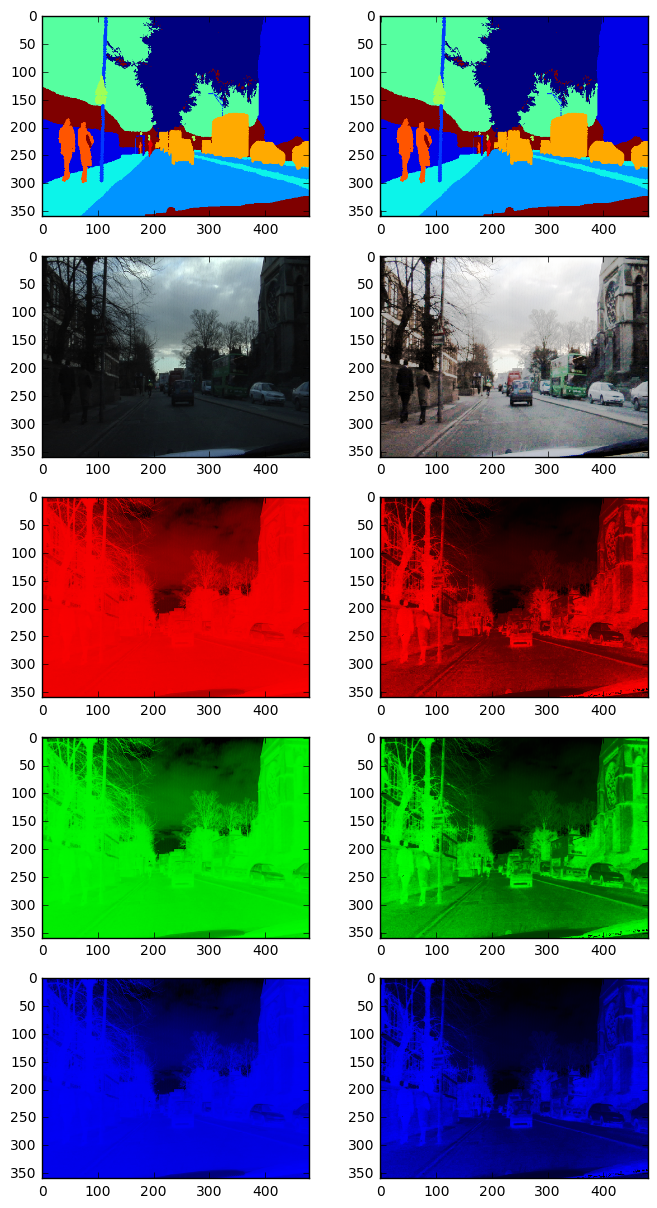

In [2]:
#x = 'data/test/0001TP_008550.png'
#y = 'data/testannot/0001TP_008550.png'
x = 'data/train/0001TP_007140.png'
y = 'data/trainannot/0001TP_007140.png'

img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
norm = np.ones(img.shape, img.dtype)*255
norm[:,:,0] = cv2.equalizeHist(img[:,:,0])
norm[:,:,1] = cv2.equalizeHist(img[:,:,1])
norm[:,:,2] = cv2.equalizeHist(img[:,:,2])

mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
annot = np.zeros(mask.shape, np.uint8)
for i in range(12): annot[np.where(mask == i)] = 255/12*i

mat1 = [
    [
        lambda x: plt.imshow(mask),
        lambda x: plt.imshow(annot),
    ],
    [
        lambda x: plt.imshow(img),
        lambda x: plt.imshow(norm),
    ]
]

for ch in range(3):
    mat1.append([
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = img[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = norm[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
    ])

mtx_plot(mat1, ratio=(4,3))


# prediction

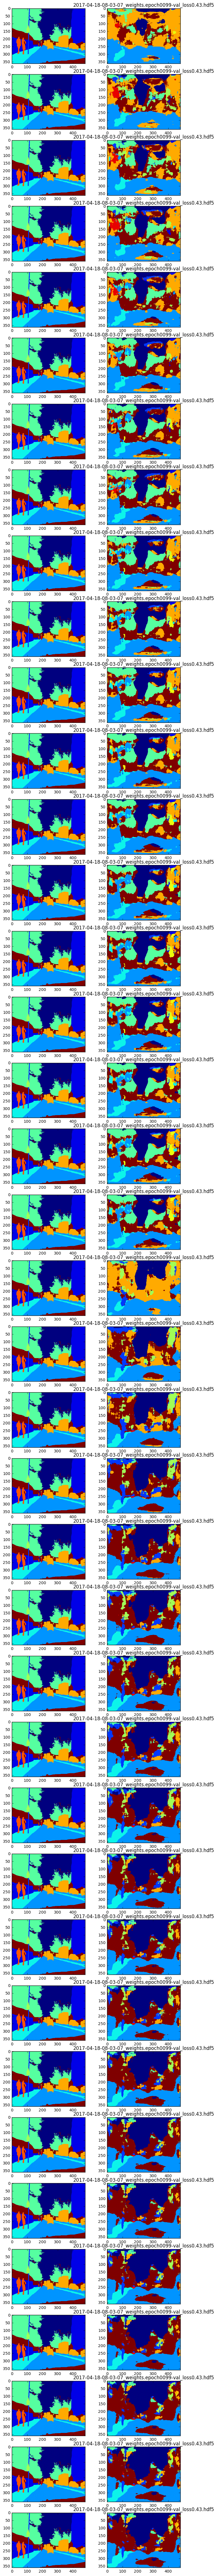

In [6]:
import tensorflow as tf
from keras.models import model_from_json
from SegNet import create_segnet


def trims(lines: str): return [line.strip() for line in lines.split("\n") if line != ""]

modes = [trims('''
2017-04-18-07-58-33_indices_weights.epoch0004-val_loss0.39.hdf5
2017-04-18-07-58-33_indices_weights.epoch0009-val_loss0.41.hdf5
2017-04-18-07-58-33_indices_weights.epoch0014-val_loss0.41.hdf5
2017-04-18-07-58-33_indices_weights.epoch0019-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0024-val_loss0.41.hdf5
2017-04-18-07-58-33_indices_weights.epoch0029-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0034-val_loss0.41.hdf5
2017-04-18-07-58-33_indices_weights.epoch0039-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0044-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0049-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0054-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0059-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0064-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0069-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0074-val_loss0.42.hdf5
2017-04-18-07-58-33_indices_weights.epoch0079-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0084-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0089-val_loss0.43.hdf5
2017-04-18-07-58-33_indices_weights.epoch0094-val_loss0.43.hdf5
'''), trims('''
2017-04-18-08-03-07_weights.epoch0004-val_loss0.41.hdf5
2017-04-18-08-03-07_weights.epoch0009-val_loss0.41.hdf5
2017-04-18-08-03-07_weights.epoch0014-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0019-val_loss0.41.hdf5
2017-04-18-08-03-07_weights.epoch0024-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0029-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0034-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0039-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0044-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0049-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0054-val_loss0.42.hdf5
2017-04-18-08-03-07_weights.epoch0059-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0064-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0069-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0074-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0079-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0084-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0089-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0094-val_loss0.43.hdf5
2017-04-18-08-03-07_weights.epoch0099-val_loss0.43.hdf5
''')]


mat2 = []
               
with tf.device('/cpu:0'):
    
    for weights in modes:
        for file_name in weights:
            model = create_segnet(shape=(480, 360, 3), nb_class=12, indices=True)
            model.load_weights(file_name)

            frame = np.expand_dims(np.einsum('hwc->whc', norm), axis=0)
            output = model.predict(frame)
            assert output.shape == (1, 480, 360, 12)
            output = np.einsum('whc->hwc', output[0])
            assert output.shape == (360, 480, 12)
            output = np.argmax(output, axis=2)
            assert output.shape == (360, 480)
            assert output.dtype == "int64"
            '''
            _annot = np.zeros(annot.shape, np.uint8)
            for i in range(12): _annot[np.where(output == i)] = 255/12*i
            '''
            mat2.append([
                (lambda annot: lambda x: plt.imshow(annot))(annot),
                (lambda _annot: lambda x: (plt.imshow(_annot), plt.title(file_name)))(output),
            ])



mtx_plot(mat2, ratio=(4,3))